<h1>Импорт метрик</h1>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id"):
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

<h1>Анализ результатов</h1>

Количество уникальных рекомендаций: 1468


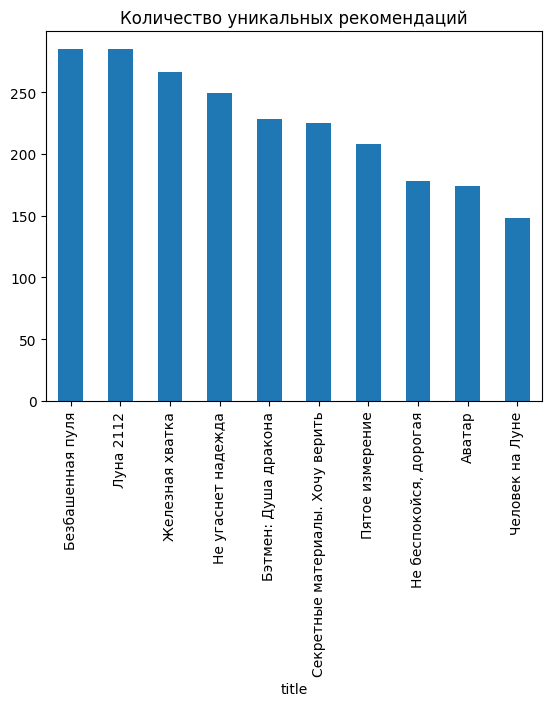

In [2]:


movies = pd.read_csv("data/items_df.csv")
movies = movies.rename(columns={"id":"preds"})

test_data = pd.read_csv("test_evaluations.csv")
test_data["preds"] = test_data["preds"].apply(lambda x: eval(x))
test_data["movie_id"] = test_data["movie_id"].apply(lambda x: eval(x))

test_movies = pd.merge(test_data.explode("preds"),movies, on = ["preds"])

test_movies = test_movies.value_counts("title").to_frame()
test_movies = test_movies.sort_values("count",ascending=False)

print("Количество уникальных рекомендаций:",len(test_movies))

test_movies["count"][:10].plot(kind="bar",title = "Количество уникальных рекомендаций")
plt.show()

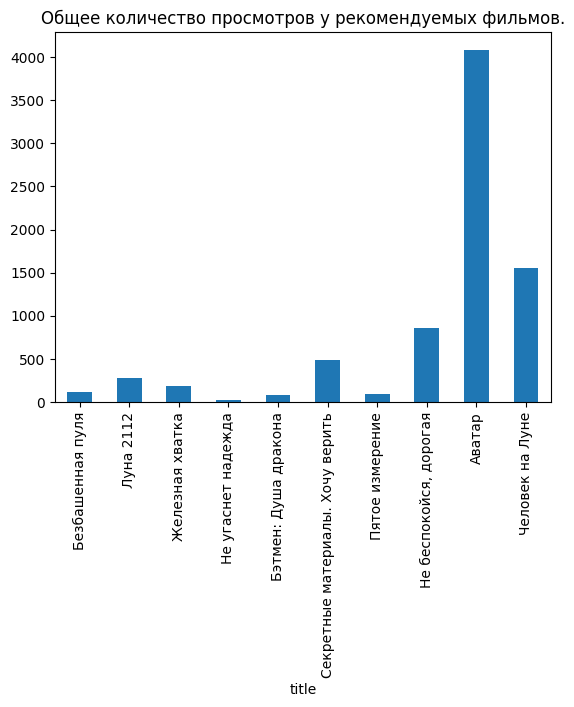

In [3]:
views = pd.read_csv("data/train_data.csv")
views = pd.merge(movies, views, how="inner", left_on='preds', right_on='movie_id')
#views = views.set_index("title")

all_movies = views.value_counts("title").to_frame()
all_movies = all_movies.rename(columns={"count":"all_count"})
all_movies = pd.concat([test_movies,all_movies],axis=1,join = "inner")
all_movies = all_movies.sort_values("count",ascending=False)

all_movies["all_count"][:10].plot(kind="bar",title = "Общее количество просмотров у рекомендуемых фильмов.")
plt.show()


Можно сделать вывод, что обученная система рекомендует пользователям фильмы средней популярности.

Далее рассчитаем метрики ndcg и recall.

In [4]:
print("Основное решение.")
print(evaluate_recommender(test_data, model_preds_col="preds"))

Основное решение.
{'ndcg': 0.01615575807787904, 'recall': 0.01512013256006628}


Метрики baseline решения.

In [5]:
baseline_data = pd.read_csv("baseline_evaluations.csv")
baseline_data["preds"] = baseline_data["preds"].apply(lambda x: eval(x))
baseline_data["movie_id"] = baseline_data["movie_id"].apply(lambda x: eval(x))
print("Baseline решение.")
print(evaluate_recommender(baseline_data, model_preds_col="preds"))

Baseline решение.
{'ndcg': 0.03584246852290217, 'recall': 0.033140016570008285}


К сожалению, моё решение не смогло опередить baseline, возможно не достаточно обучил модель, или неправильно подобраны гиперпараметры, но по крайнем мере, было интересно попробовать использовать двухбашенную нейронную сеть для рекомендательной системы.